In [14]:
# Import all required packages
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import xarray as xr
import numpy as np
from datetime import datetime, time, timedelta
import calendar
import random
from pprint import pprint
from typing import List, Dict, Optional, Union
from pathlib import Path
import pytz

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 5

import sys
sys.path.insert(0, "/home/raj/ocf/pv-solar-farm-forecasting/ukpn/load/gsp/power_data")
sys.path.insert(0, "/home/raj/ocf/pv-solar-farm-forecasting/ukpn/load/gsp/meta_data")

from gsp_power_data_utils import *
from gsp_meta_data_utils import *

%matplotlib inline

## UKPN Dashboard Data Report
---

### <u>Introduction</u>
For the complete Jupyter notebook with code and its respective codebase please visit this github [link](https://github.com/openclimatefix/pv-solar-farm-forecasting/blob/raj/ukpn_dashboard_data/ukpn/scripts/ukpn_dashboard_report.ipynb)

[UKPN dashbaord](https://dsodashboard.ukpowernetworks.co.uk/d/jnTAkg7Gz/ukpn-dso-dashboard-grid-supply-areas?orgId=1&from=now-1y&to=now&refresh=10m&var-GSP=CANTERBURY%20NORTH) is provided by the organisation called "[UK Power Netowrks](https://www.ukpowernetworks.co.uk/)" through an open source analytics and monitroing interface called [Grafana](https://grafana.com/). It provides various metrics from the GSP such as Active Power Flow, Reactive Power Flow, Voltage , Frequency and Generator Outputs for all metered generation. For this data report, solar data generated from metered outputs has been considered. The data that can be manually downladable is in either csv or JSON format.

In [15]:
# Plotting a bar graph
folder_destination = "/home/raj/ocf/pv-solar-farm-forecasting/tests/data/ukpn_dashboard_data"
count_dict = get_gsp_data_in_dict(
    folder_destination = folder_destination,
    count_gsp_data = True)
# Printing the total number of GSP's
print(f"The total number of Solar data points in each GSP locaion is as follows")
pprint(count_dict)

The total number of Solar data points in each GSP locaion is as follows
{'braintree': 160819,
 'burwell': 161114,
 'canterbury_north': 161763,
 'ninefield': 161942,
 'northfleet_east': 160720,
 'norwich': 161272,
 'rayleigh': 155842,
 'richborough': 54767,
 'sellindge': 161864}


All the GSP Power data has been downloaded manually from the [dashboard](https://dsodashboard.ukpowernetworks.co.uk/d/jnTAkg7Gz/ukpn-dso-dashboard-grid-supply-areas?orgId=1&from=now-1y&to=now&refresh=10m&var-GSP=CANTERBURY%20NORTH), but it will be automated as we move forward. The frequency of the data is 10Min, GSP's has different starting dates in their historic data, but it is live data, meaning the data downloaded will be upto the last 10th minute in the current hour of the current day.

In [16]:
# Getting the starting dates of each GSP data
data_dict = get_gsp_data_in_dict(folder_destination = folder_destination)
starting_dates = {}
ending_date = []
minutes_each_gsp = []
for gsp_name, data_frame in  data_dict.items():
    # Getting the starting dates adn ending date
    starting_dates[gsp_name] = data_frame.first_valid_index().strftime("%Y-%m-%d")
    ending_date.append(data_frame.last_valid_index().strftime("%Y-%m-%d"))
    # Getting the minutes
    data_frame["minutes"] = pd.to_datetime(data_frame.index).minute
    minutes = data_frame["minutes"].unique().tolist()
    minutes_each_gsp.append(minutes)

print("\nMost of the data has similar starting dates, and below are the common starting dates")
print(set(list(starting_dates.values())))
print("And the last or latest date for the current dataset is:")
print(set(list(ending_date)))

print("\nThe interval frequency of all the GSP solar data in each hour is as follows:")
pprint(np.unique(minutes_each_gsp).tolist())

# Getting the path of the file
canterbury_path_to_file = Path("/home/raj/ocf/pv-solar-farm-forecasting/tests/data/ukpn_dashboard_data/canterbury_north.csv")
richbourough_path_to_file = Path("/home/raj/ocf/pv-solar-farm-forecasting/tests/data/ukpn_dashboard_data/richborough.csv")
canterbury_df = load_csv_to_pandas(path_to_file = canterbury_path_to_file)
richbourough_df = load_csv_to_pandas(path_to_file = richbourough_path_to_file)
print("\nTop 5 rows of a couple of GSP's can be seen below:")
print(canterbury_df.head(5))
print(richbourough_df.head(5))

# BST to UTC conversion
canterbury_df_utc = bst_to_utc(
    original_df = canterbury_df
)


Most of the data has similar starting dates, and below are the common starting dates
{'2019-12-16', '2019-12-23', '2021-12-30'}
And the last or latest date for the current dataset is:
{'2023-01-16'}

The interval frequency of all the GSP solar data in each hour is as follows:
[0, 10, 20, 30, 40, 50]

Top 5 rows of a couple of GSP's can be seen below:
                     canterbury_north
time_utc                             
2019-12-16 00:00:00               1.5
2019-12-16 00:10:00               1.5
2019-12-16 00:20:00               1.5
2019-12-16 00:30:00               1.6
2019-12-16 00:40:00               1.6
                     richborough
time_utc                        
2021-12-30 00:00:00         0.29
2021-12-30 00:10:00         0.29
2021-12-30 00:20:00         0.29
2021-12-30 00:30:00         0.30
2021-12-30 00:40:00         0.30


---
From above it is observed that, the data for each GSP spans from '2021-12-xx' to '2023-01-16', and it is of 10 minute intervaled data.

The data contains float values for each time stamp, and it is observed that there are negative values present in between after a rough look through the raw data. There are no NaN's present in the raw data, but there are 

1. missing time intervals
2. negative values
3. Duplicate Datetime timestamps


---
### <u>Negative Solar Data</u>
There are no NaN's present in the raw data, but the negative values are quite spreadout and there is no proper trend observed of negative values in the raw data. The percentage of negative values for each month in each GSP has been plotted below.

The check for NaN values has been performed!
No NaN Values are found in any GSP raw data

Checking for negative data:
Below are the GSP names with percentage of total negative values in their data




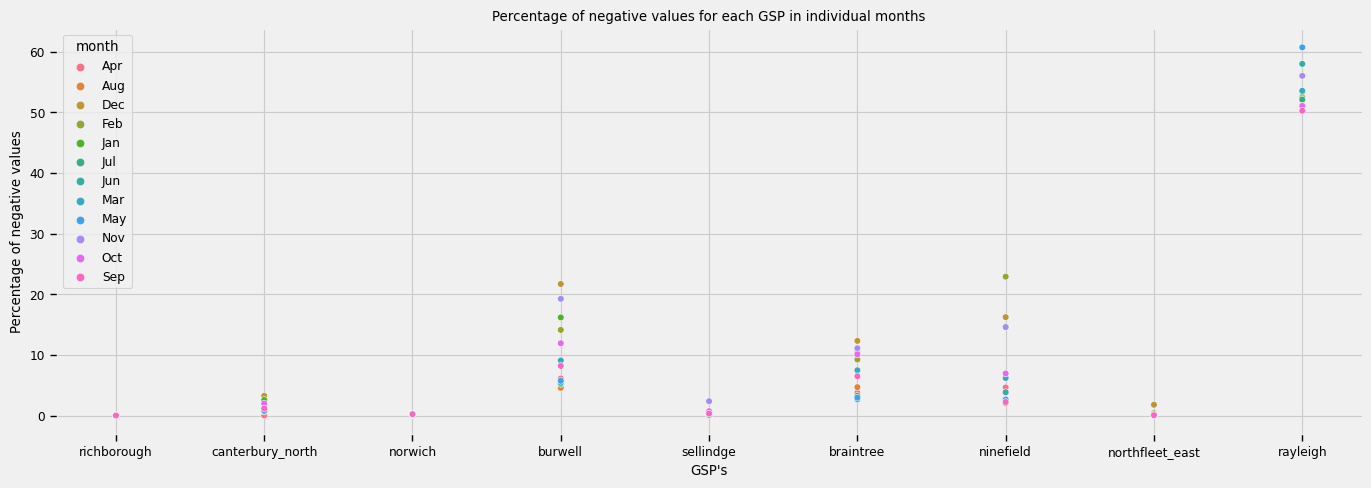

In [25]:
# Checks in pre-processing
check_nan = []
count_df = pd.DataFrame()

for gsp_name, data_frame in data_dict.items():

    # Checking NaN's
    check_nan = data_frame.isnull().any().any()

    # Checking negative data
    negative_data_check = np.sum((data_frame[data_frame.columns[0]] < 0).values.ravel())
    # Getting months
    data_frame["month"] = pd.to_datetime(data_frame.index).month.values
    data_frame["month"] = data_frame["month"].apply(lambda x: calendar.month_abbr[x])
    # Group by months
    groupby_month = data_frame.groupby('month')[gsp_name]
    counts = groupby_month.agg(
        pos_count=lambda s: s.gt(0).sum(),
        neg_count=lambda s: s.lt(0).sum(),
        net_count=lambda s: s.gt(0).sum()- s.lt(0).sum()).astype(int)
    
    counts["perc_count"] = (counts["neg_count"]/(counts["pos_count"] + counts["neg_count"])) * 100

    counts["gsp_name"] = gsp_name
    counts = counts.reset_index(level=0)
    count_df = pd.concat([count_df, counts], ignore_index = True)

# Check for NaN's
print("The check for NaN values has been performed!")
if check_nan == True:
    print("There are NaN values")
else:
    print("No NaN Values are found in any GSP raw data")

# Check for negative data
print("\nChecking for negative data:")
print("Below are the GSP names with percentage of total negative values in their data")
sns.set_context('paper')
sns.scatterplot(
    data = count_df, 
    x = "gsp_name", 
    y = "perc_count", 
    hue = "month")
plt.title("Percentage of negative values for each GSP in individual months")
plt.xlabel("GSP's")
plt.ylabel("Percentage of negative values")
print("\n")

---
### <u>Missing and Duplicated Time Intervals</u>
In the current dataset, for each GSP, there are some missing and duplicated time intervals have been observed for each year respectively. After careful observation and suggestion by a colleague, it has been noted that the missing and duplicated time intervals correspond to the daylight saving times of the year, which means there is an hour of data has been missing during the end of March, and there is duplication of data during the end of October. (the dates vary according to the year)

Daylight savings:<br>
Timezone: "Europe/London"<br>
Sun, Mar 29, 2020 1:00 AM - Sun, Oct 25, 2020 2:00 AM<br>
Sun, Mar 28, 2021 1:00 AM - Sun, Oct 31, 2021 2:00 AM<br>
Sun, Mar 27, 2022 1:00 AM - Sun, Oct 30, 2022 2:00 AM<br>

Hypothesis: So according to the above observation, __there should not be any missing intervals other than March__ and __there should not be any duplicated time intervals other than October.__ Checks have been connected to test this hypothesis on the yearly basis for each GSP, and the anomaly years have been noted below along with their corresponding GSPs.

_Block: Typically, in a timeseries data in local timezone (in the current context- BST),there would be one hour of missing data in March and One hour of duplicated data in October. But, there are two missing hours instead of one in March if daylight savings are considered, this means even after adjusting for the one hour of the daylight savings, there is still one hour of data missing in the dataset_

In [18]:
# Daylight saving dates
# Accrording to the web search these are the dates of daylight savings in the years respectively
missing_March_daylight_saving_dict = {
    # Year : Date
    2020 : 29,
    2021 : 28,
    2022 : 27
}
duplication_October_daylight_saving_dict = {
    # Year : Date
    2020 : 25,
    2021 : 31,
    2022 : 30
}

# Getting the years of GSP where there are missing values other than month of March 
missing_dict = {}
for gsp_name, df in data_dict.items():
    df_without_duplicated= df[~df.index.duplicated(keep = 'first')]
    final_df = df_without_duplicated.asfreq('10Min')   
    # Getting the missing time intervals
    final_df = final_df[final_df[final_df.columns[0]].isna()]
    missing_values_years = pd.to_datetime(final_df.index).year.values
    missing_dict[gsp_name] = np.unique(missing_values_years).tolist()

# Getting the years of GSP where there are duplicates other than month of October
final_dict = {}
for gsp_name, df in data_dict.items():
    duplicate_dict = check_duplicates(
        original_df = df)
    for key, value in duplicate_dict.items():
        final_dict[key] = value

print("The following years of GSP's has duplicated time intervals other than October")
pprint(final_dict)
print("\nThe following years of GSP's has missing time intervals other than March")
pprint(missing_dict)

The following years of GSP's has duplicated time intervals other than October
{'braintree': 2021,
 'burwell': 2021,
 'canterbury_north': 2021,
 'ninefield': 2021,
 'northfleet_east': 2021,
 'norwich': 2021,
 'sellindge': 2021}

The following years of GSP's has missing time intervals other than March
{'braintree': [2020, 2021, 2022],
 'burwell': [2020, 2021, 2022],
 'canterbury_north': [2020, 2021, 2022],
 'ninefield': [2019, 2020, 2021, 2022],
 'northfleet_east': [2020, 2021, 2022],
 'norwich': [2020, 2021, 2022],
 'rayleigh': [2020, 2021, 2022],
 'richborough': [2022],
 'sellindge': [2020, 2021, 2022]}


### <u>Observations</u>
---
1. Looking at the raw data, there has been a trend observed in the generated metered power values in a day. The power values which are in MW for each GSP, starts to rise linearly from the midnight, and starts spiking during a certain time of the day. It is fair assumption to think those spikes starts at the Sunrise time of the GSP location. After plotting the data against the __Sunset__ and __Sunrise__ times (Source - [link](https://www.timeanddate.com/astronomy/uk/canterbury)) of the __Canterbury__ GSP, the observation seems to be true.

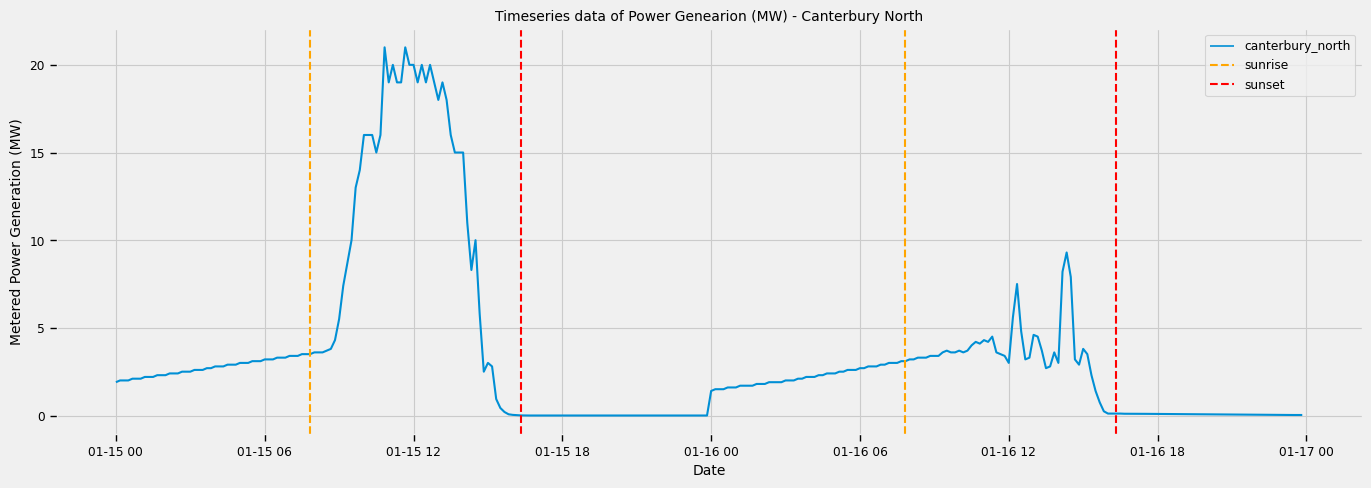

In [19]:
# Plotting Canterbury Metered power generation for the current month (18/01/2023)

# Loading the file
path_to_file = Path("/home/raj/ocf/pv-solar-farm-forecasting/tests/data/ukpn_dashboard_data/canterbury_north.csv")
canterbury_df = load_csv_to_pandas(path_to_file = path_to_file)

# Getting the 2023 Jan data
canterbury_df_jan = canterbury_df[canterbury_df.index.year == 2023]
canterbury_df_jan = canterbury_df_jan[np.in1d(canterbury_df_jan.index.day.values, [15,16,17])]

# Sunrise and Sunset time
def set_sunrise_sunset_times(
    orignal_df = pd.DataFrame,
    sunrise_time: time = time(7, 50),
    sunset_time: time = time(16,20)
):
    sunrise_time = orignal_df[np.in1d(orignal_df.index.time, sunrise_time)].index.values
    sunset_time = orignal_df[np.in1d(orignal_df.index.time, sunset_time)].index.values
    return(sunrise_time, sunset_time)

canterbury_jan_sunrise_time, canterbury_jan_sunset_time = set_sunrise_sunset_times(orignal_df = canterbury_df_jan)

def legend_without_duplicate_labels(figure):
    """Prevents legend labels from duplicating
    link - https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib
    """
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    figure.legend(by_label.values(), by_label.keys(), loc='upper right')

# Plotting
def plotting_singledays(
    original_df: pd.DataFrame,
    sunrise_time: List,
    sunset_time: List,
    plt_title: str
):
    sns.lineplot(data = original_df, linewidth = 1.5)
    for i in range(len(sunrise_time)):
        plt.axvline(sunrise_time[i], linewidth = 1.5, color = 'orange', linestyle = '--', label = 'sunrise')
        plt.axvline(sunset_time[i], linewidth = 1.5, color = 'red', linestyle = '--', label = 'sunset')
        # Naming legend
        legend_without_duplicate_labels(plt)
        plt.title(plt_title, fontsize = 10)
        plt.xlabel("Date", fontsize = 10)
        plt.ylabel("Metered Power Generation (MW)", fontsize = 10)

plotting_singledays(
    original_df = canterbury_df_jan,
    sunrise_time = canterbury_jan_sunrise_time,
    sunset_time = canterbury_jan_sunset_time,
    plt_title = "Timeseries data of Power Genearion (MW) - Canterbury North")

---
2. To observe the seasonal variation of average power in a typical day, there has to be a distinct difference in the power outputs. It is true that seasonal variations causes shift in the solar output from the solar arrays, hence the plot below classifies and makes a distinction between each season of average generated power during the mid day i.e 11am-1pm.

It has been pointed out by a colleague that it would be a good observation to plot the below by hour rather than the day, as the hourly distinction is much more significant than the day. Both plots can be seen below

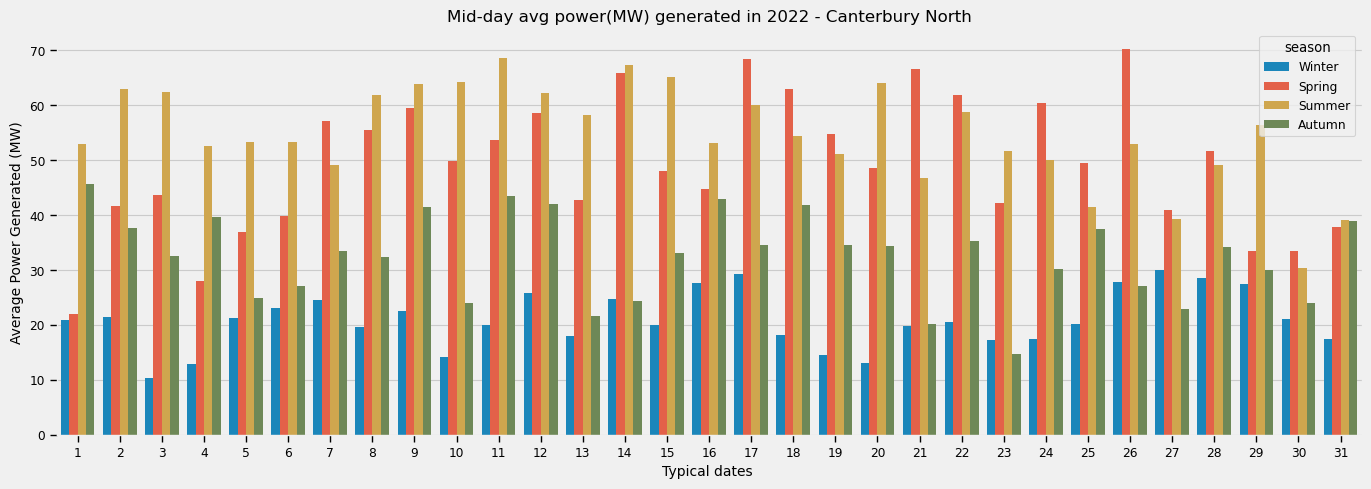

In [20]:
# Classification of power generated by seasons

# Defining Seasons
seasons = {
    1 : "Winter",
    2 : "Winter",
    3 : "Spring",
    4 : "Spring",
    5 : "Spring",
    6 : "Summer",
    7 : "Summer",
    8 : "Summer",
    9 : "Autumn",
    10 : "Autumn",
    11 : "Autumn",
    12 : "Winter"
}

# Path file
path_to_file = Path(r"/home/raj/ocf/pv-solar-farm-forecasting/tests/data/ukpn_dashboard_data/canterbury_north.csv")

def plot_classification_of_pv(
    path_to_file: Path[Union, str],
    axes_title: str = None, # 'Mid-day' or 'hourly'
    name_col2: str = None, # 'date' or 'hour'
    daily_avg: Optional[bool] = None,
    hourly_avg: Optional[bool] = None
):
    canterbury_df = load_csv_to_pandas(path_to_file = path_to_file)

    # Resetting the index
    canterbury_df.reset_index(inplace=True)

    # Getting the data for only 2022
    canterbury_df_2022 = canterbury_df[canterbury_df["time_utc"].dt.year == 2022].reset_index(drop=True)

    # Getting the data for the mid-day 11am to 1pm
    canterbury_df_2022 = canterbury_df_2022.set_index("time_utc")

    if daily_avg:
        canterbury_df_2022  = canterbury_df_2022.between_time('11:00', '13:00')        
        # Getting the average for a single day
        canterbury_avg_2022 = canterbury_df_2022.groupby([
            canterbury_df_2022.index.month, canterbury_df_2022.index.day])["canterbury_north"].mean().to_frame()
    if hourly_avg:
        # Gettng the avergae by the hour
        canterbury_avg_2022 = canterbury_df_2022.groupby([
            canterbury_df_2022.index.month, canterbury_df_2022.index.hour])["canterbury_north"].mean().to_frame()

    # Getting the seasons of the year
    canterbury_avg_2022.index.set_names(['month' , name_col2], inplace = True)
    canterbury_avg_2022.reset_index(inplace = True)
    canterbury_avg_2022["season"] = canterbury_avg_2022["month"].apply(lambda month_number: seasons[month_number])
    canterbury_avg_2022["month"] = canterbury_avg_2022["month"].apply(lambda month_number: calendar.month_abbr[month_number])

    # Plot the data
    # This plot classifies the average power generated on every mid-day (11am - 1pm) of a season day
    # For example, the first bar represents the average of 1st day of every month in a season
    ax = sns.barplot(data = canterbury_avg_2022, x = name_col2 , y = 'canterbury_north', hue = "season", ci = None)
    ax.set_xlabel(f'Typical {name_col2}s ', fontsize = 10)
    ax.set_ylabel('Average Power Generated (MW)', fontsize = 10)
    ax.axes.set_title(f"{axes_title} avg power(MW) generated in 2022 - Canterbury North", fontsize = 12)
    plt.show
    
# Plotting Mid-day avergae     
plot_classification_of_pv(
    path_to_file = path_to_file,
    axes_title = 'Mid-day',
    name_col2 = 'date',
    daily_avg = True)

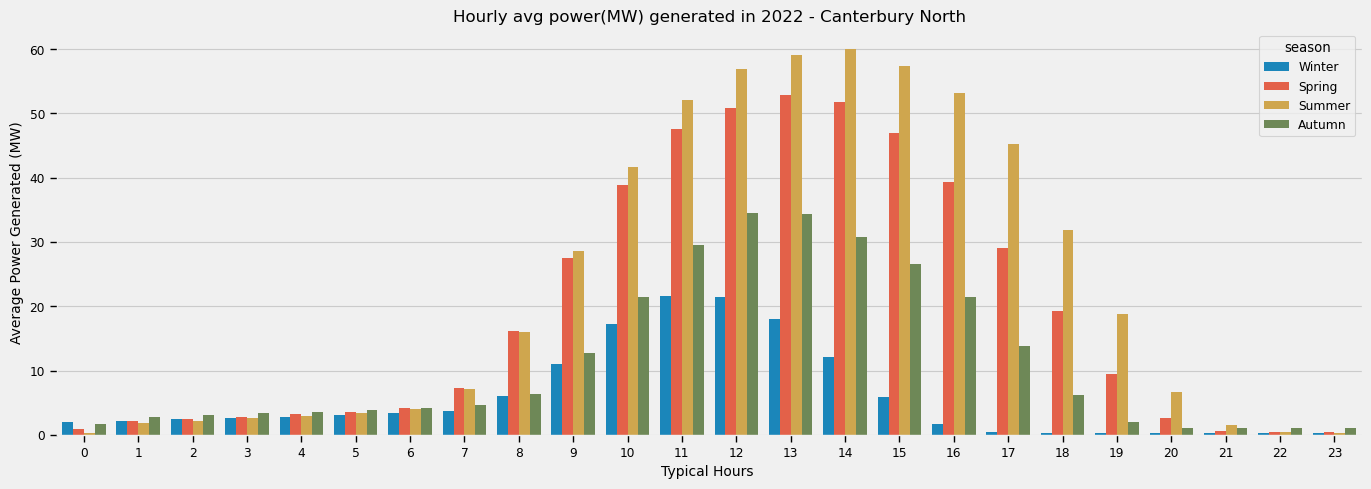

In [21]:
# Plotting hourly average
plot_classification_of_pv(
    path_to_file = path_to_file,
    axes_title = 'Hourly',
    name_col2 = 'Hour',
    hourly_avg = True
)

---
3. The difference between a typical summer and winter days can be observed in the solar data time series plot, as the plot stretches itself along the time (X-axis). This phenomenon is due to the window increase of __Sun Rise__ and __Sun Set__ times from a typical winter day to a summer day. Plots of both days can be found below. 

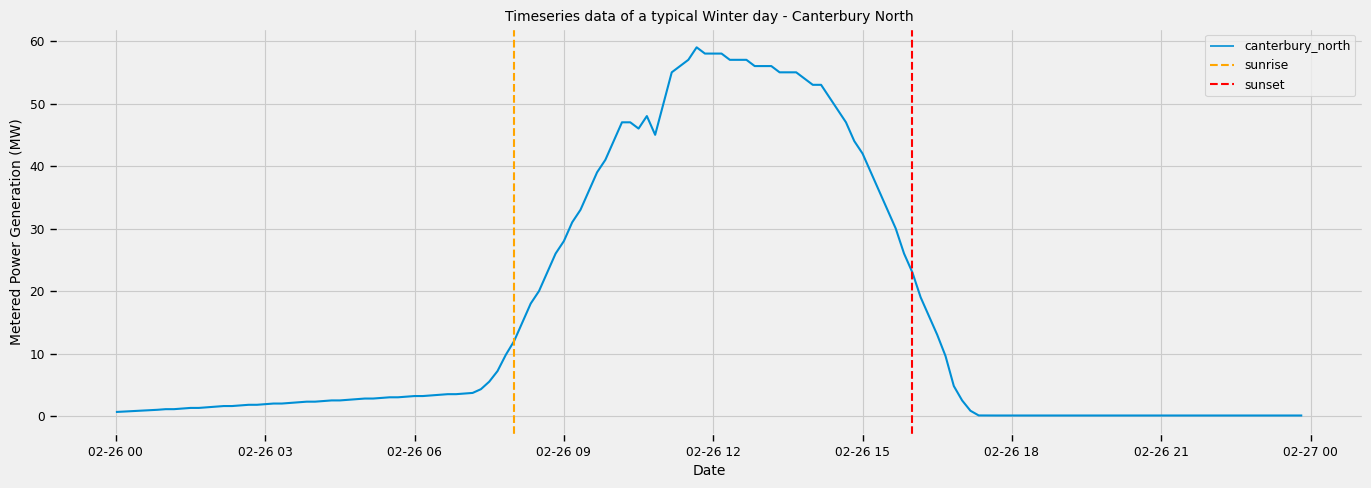

In [22]:
# Loading the file
np.random.seed(400)
path_to_file = Path(r"/home/raj/ocf/pv-solar-farm-forecasting/tests/data/ukpn_dashboard_data/canterbury_north.csv")
canterbury_df = load_csv_to_pandas(path_to_file = path_to_file)
canterbury_df_2022 = canterbury_df[pd.to_datetime(canterbury_df.index).year == 2022]

# Ploting for a typical summer and winter day in canterbury north
canterbury_df_2022["month_num"] = pd.to_datetime(canterbury_df_2022.index).month.values
canterbury_df_2022["season"] = canterbury_df_2022["month_num"].apply(lambda month_number: seasons[month_number])
canterbury_df_2022 = canterbury_df_2022.drop(['month_num'], axis = 1)

def get_season_df(
    original_df: pd.DataFrame,
    select_season: str
):
    season_group = original_df.groupby('season')
    for season_name, group_df in season_group:
        if season_name == select_season:
            random_date = random.choice(group_df.index)
            random_date = pd.to_datetime(random_date).strftime("%Y-%m-%d")
            season_df = group_df[group_df.index.strftime("%Y-%m-%d") == random_date]
    return season_df

winter_df = get_season_df(original_df = canterbury_df_2022, select_season = "Winter")
summer_df = get_season_df(original_df = canterbury_df_2022, select_season = "Summer")

winter_sunrise, winter_sunset = set_sunrise_sunset_times(
    orignal_df = winter_df,
    sunrise_time = time(8, 0),
    sunset_time = time(16, 0))

summer_sunrise, summer_sunset = set_sunrise_sunset_times(
    orignal_df = summer_df,
    sunrise_time = time(5, 0),
    sunset_time = time(21, 0)
)
# Plotting a typical Summer and Winter day
plotting_singledays(
    original_df = winter_df,
    sunrise_time = winter_sunrise,
    sunset_time = winter_sunset, 
    plt_title = "Timeseries data of a typical Winter day - Canterbury North")


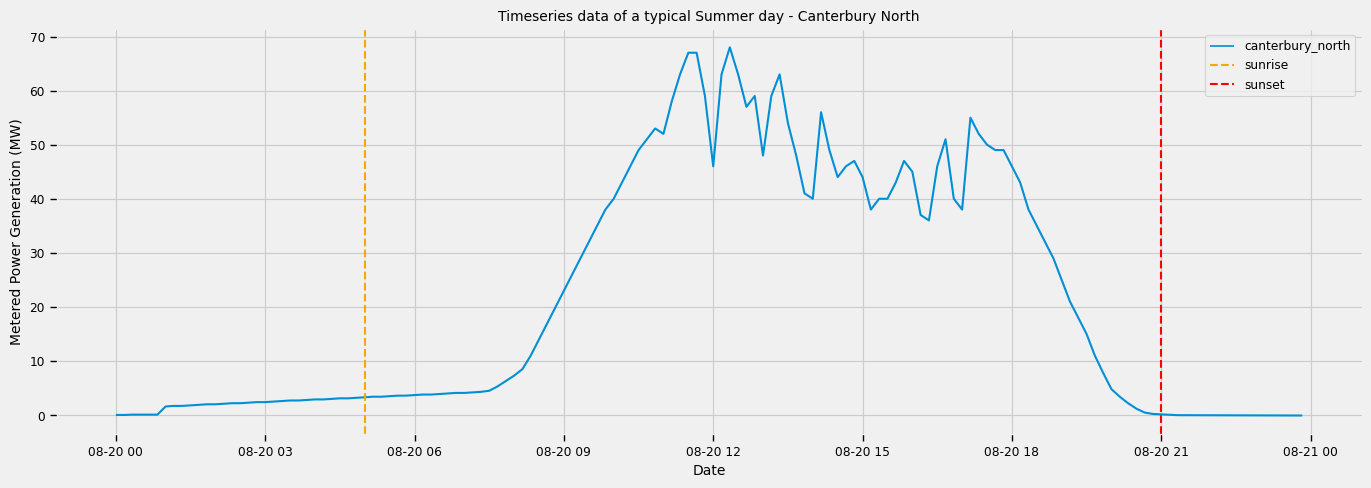

In [23]:
plotting_singledays(
    original_df = summer_df,
    sunrise_time = summer_sunrise,
    sunset_time = summer_sunset, 
    plt_title = "Timeseries data of a typical Summer day - Canterbury North")

---
### <u>UKPN Dashboard data tasks</u>

PVLive Estimate GSP data has been downloaded from [GCP platform](https://console.cloud.google.com/storage/browser/solar-pv-nowcasting-data/PV/GSP/v5?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&authuser=1&project=solar-pv-nowcasting&prefix=&forceOnObjectsSortingFiltering=false) using Google Cloud SDK into the remote server for the comparison of the data to the UKPN GSP data. The PVLive data is in the Zarr format with a single dataset of two dimensions (datetime and gsp id). UKPN GSP time series data has different starting dates, after pre-processing and got the data into a single netcdf file to compare with the PVLive GSP data.

<u>Observations</u>: <br>

1. <u>Comparing with GSP solar data with PVLive Estimates</u>: <br>
The data is represented in two dimesntions. And the dimesion of GSP id has continous integers respresenting each GSP. It is yet to understand a relative connection of which PVLive GSP is equal to UKPN GSP. Apart from that, UKPN data can be expoerted to NetCDF for the comparison.

2. <u>Automating the download of the data</u>: <br>
The GSP data from the UKPN dashboard can be downloaded manually. But on eof colleague has suggested that we can automate the download the current time through a shell script. 

In [ ]:
# Interpolating the negative values in the data frame

# Loading the file
path_to_file = "/home/raj/ocf/pv-solar-farm-forecasting/tests/data/ukpn_dashboard_data/canterbury_north.csv"
canterbury_df = load_csv_to_pandas(path_to_file = path_to_file)


# Getting the indices of the negative values
canterbury_negative_indices = check_for_negative_data(original_df = canterbury_df)
unique_dates_with_negative = canterbury_negative_indices.map(lambda t: t.date()).unique()

# Converting the dates to list
select_dates = random.sample(unique_dates_with_negative.to_list(), 1)

# Getting the required dataframe
final_dataframe = pd.DataFrame([])

for i in range(len(select_dates)):
    # Filtering dataframe based on each date with negative values
    originL_df = canterbury_df.loc[pd.to_datetime(canterbury_df.index.values).date == select_dates[i]]
    filter_df = check_for_negative_data(original_df = originL_df, replace_with_nan = True)

    # Interpolating the missing values
    start_date = select_dates[i].strftime("%Y-%m-%d")
    end_date = (datetime.strptime(start_date, "%Y-%m-%d") + timedelta(days = 1)).strftime("%Y-%m-%d")
    interpolated_df = interpolation_pandas(
        original_df = filter_df, 
        start_date = start_date,
        end_date = end_date,
        freq = "10Min",
        drop_last_row = True)
    
    # Dropping the duplicates
    interpolated_df = interpolated_df[~interpolated_df.index.duplicated(keep = 'first')]
    print(interpolated_df[interpolated_df.columns[0]].values)
    # Concating with the final dataframe
    final_dataframe = pd.concat([final_dataframe, interpolated_df])



In [ ]:
def first_plot(
    path_to_file: str
    ):
    # Getting the original data frame
    original_df = load_csv_to_pandas(path_to_file=path_to_file)

    # Getting the slopes of every two rows for the entire data frame column
    original_df["slope"] = original_df["test"].rolling(window = 2).apply(lambda x: x[1]-x[0])
    original_df["slope"] = original_df["slope"].fillna(0)

    # Getting the dates of the days with slopes range 
    active_timestamps = original_df[~original_df["slope"].between(-1.5, 1.5)]

    # Getting the most common times of the data with active power
    active_timestamps = active_timestamps.index.time
    print(np.unique(active_timestamps))
    

    # derivative = original_df[original_df.columns[0]].diff() / original_df.index.to_series().diff().dt.total_seconds()
    # original_df["trend"] = derivative.gt(0).map({False : '-1', True : '1'})
    # print(original_df.head(20))
    original_df = original_df.head(144)
    original_df.plot(y="test", use_index=True)
    plt.xlabel("Date Range")
    plt.ylabel("Gnenerated metered power (MW)")
    plt.title("Time series data of power generated")
    plt.show()


In [ ]:
def check_daylight_savings(
    original_df: pd.DataFrame,
    march_daylight_dict: Dict,
    october_daylight_dict: Dict,
    freq :str = '10Min'
    ):
    """This functions checks if there are missing and duplicated
    time intervals due to daylight savings
    
    Args:
        original_df: Loaded data frame from the csv file
    """
    def get_month_data(
        original_df: pd.DataFrame,
        month_abbr: str
    ):
        # Getting the March data
        month_df = original_df[
            pd.to_datetime(month_df.index).year.values == list(calendar.month_abbr).index(month_abbr)]
        month_df = month_df.between_time('00:00', '03:00')
        return month_df

    # Getting the March and October data into a dictionary 
    # {'March': <pd.Dataframe> , 'Oct':<pd.Dataframe>}
    data_dict = {}
    Months = ['Mar', 'Oct']
    for i in range(len(Months)):
        df = get_month_data(
            original_df = original_df,
            month_abbr = Months[i])
        data_dict[Months[i]] = df

    # Going through each monthly data
    for month_abbr, data_frame in data_dict.items():
        # Getting the dictionary daylight savings dates
        if month_abbr == 'Mar':
            daylight_dict = march_daylight_dict
        if month_abbr == 'Oct':
            daylight_dict = october_daylight_dict
            
        df_years = pd.to_datetime(data_frame.index).year.values
        df_years = np.unique(df_years)

        for i in range(len(df_years)):
            df = data_frame[pd.to_datetime(data_frame.index).year.values == df_years[i]]
            df = df.asfreq(freq)
            check = df.isnull().val